# 04b Rank CATE estimators TC (cfd_cardio)

In the previous notebook, we saw that estimators do not have good prediction performance, and neither are  
they sufficiently stable in general. On the other hand, the banded ordering of individuals generalizes. In  
this notebook, we measure this generalization performance in terms of the $t$-statistic. We rank the  
various estimators w.r.t. this statistic, and select the ones with which to form an ensemble.

The data perturbations are:  
1. No perturbation  
2. Stratified CV split with different random seed  
3. Another stratified CV split with different random seed  
4. CV split using enrollment time to define folds  
5. Replacing overweight feature with obese (using a different BMI threshold)  
6. Changing age threshold for elderly feature from 65 to 60  
7. Changing the outcome of interest to all GI events instead of just confirmed GI events  

### Contents:
1. Set up  
1.1. Create, save and/or load the scores data frame  
2. Aggregate the $t$-statistics in various ways  
2.1. Aggregate within each data perturbation  
2.2. Aggregate within each q value  
2.3. Aggregate over everything  
3. $t$-statistic variability  
4. Selecting the top estimators  
4.1. Further investigation and plots  
4.2. Outputting names of top estimators

## 1. Set up

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import own methods
from methods.cate_estimator_validation import (get_estimator_scores, aggregate_estimator_scores, 
                                               get_t_r2_statistics)                          

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


If scores are already cached, load them instead of running 1.1.

In [2]:
# Load the scores data frame
outcome_name = "cfd_cardio"
scores_df = joblib.load(f"data_files/{outcome_name}/{outcome_name}_scores_df")
q_values = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
dir_neg = False

### 1.1. Create, save and/or load the scores data frame

Compute the t-statistics for the different estimators across different folds and data perturbations. Store the result in the  data frame ``scores_df``.

In [3]:
outcome_name = "cfd_cardio"
q_values = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
dir_neg = False
file_path = f"data_files/{outcome_name}/{outcome_name}_fitted_libraries"

In [4]:
fitted_libraries = joblib.load(file_path)
scores_df = get_estimator_scores(fitted_libraries, q_values, 
                                 dir_neg = dir_neg, kind = "val")
del fitted_libraries

Mean of empty slice.
invalid value encountered in double_scalars
Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars


In [5]:
# Dump the scores data frame
joblib.dump(scores_df, f"data_files/{outcome_name}/{outcome_name}_scores_df")

['data_files/cfd_cardio/cfd_cardio_scores_df']

## 2. Aggregate the $t$-statistics in various ways

#### From 03b we know "r_lassoxgb", "causal_tree_1", "s_xgb" are bad methods

In [7]:
bad_methods = ["r_lassoxgb", "causal_tree_1", "s_xgb"]

### 2.1. Aggregate within each data perturbation

In [4]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by = "perturbation")
results_df["mean"] = results_df.apply(np.mean, axis = 1)
results_df.drop(index=bad_methods).round(2).sort_values("mean", ascending=dir_neg)

,pert=cv_0,pert=overweight,pert=outcome,pert=cv_time,pert=elderly_60,pert=cv_1,pert=none,mean
estimator,,,,,,,,
s_rf,1.29,1.05,1.26,1.42,1.29,1.17,0.96,1.20
t_rf,1.19,1.18,1.45,1.25,1.24,0.90,1.10,1.19
t_lasso,1.16,1.07,1.14,1.02,1.10,0.99,1.06,1.08
t_logistic,1.16,0.93,1.02,1.17,1.17,1.03,1.10,1.08
x_xgb,1.15,1.04,1.11,1.03,1.08,0.89,1.01,1.05
x_logistic,1.11,0.92,1.01,0.94,1.14,0.87,0.97,0.99
x_rf,1.11,0.99,1.02,0.91,1.09,0.88,0.90,0.98
t_xgb,1.06,0.66,1.26,1.26,0.95,0.92,0.66,0.97
x_lasso,1.13,0.94,1.03,0.90,1.10,0.80,0.92,0.97


In [9]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name = "rank_mean", 
                                        group_by = "perturbation", dir_neg = False)
results_df["mean"] = results_df.apply(np.mean, axis = 1)
results_df.drop(index=bad_methods).sort_values("mean", ascending=True).round(2)

,pert=cv_0,pert=overweight,pert=outcome,pert=cv_time,pert=elderly_60,pert=cv_1,pert=none,mean
estimator,,,,,,,,
t_rf,7.40,6.70,5.40,6.55,6.28,9.30,6.10,6.82
s_rf,7.90,7.70,6.90,6.35,6.45,7.15,7.75,7.17
t_logistic,7.65,8.75,9.60,5.75,6.35,7.00,6.70,7.40
t_lasso,8.15,7.32,7.85,8.10,7.35,8.00,6.60,7.63
x_xgb,7.65,7.38,7.85,7.90,8.28,8.85,7.32,7.89
t_xgb,8.35,10.07,7.12,5.92,8.02,8.02,10.02,8.22
x_logistic,9.20,8.75,9.95,7.95,7.48,9.15,7.05,8.50
x_rf,8.68,7.90,9.65,9.25,7.30,9.02,8.62,8.63
x_lasso,8.90,8.75,9.40,9.20,8.10,9.90,8.35,8.94


In [116]:
# results_df = aggregate_estimator_scores(scores_df, group_by = "perturbation", 
#                                         aggregation_func_name = "top_k_freq", k = 10)
# results_df["mean"] = results_df.apply(np.mean, axis = 1)
# results_df.drop(index=bad_methods).sort_values("mean", ascending = False).round(2)

### 2.2. Aggregated within each q value

In [10]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name = "mean", 
                                        group_by = "q_value", dir_neg = False)
results_df["mean"] = results_df.apply(np.mean, axis = 1)
results_df.drop(index=bad_methods).sort_values("mean", ascending=dir_neg).round(2)

,0.1,0.2,0.3,0.4,0.5,mean
estimator,,,,,,
s_rf,1.33,1.39,1.32,1.12,0.86,1.20
t_rf,1.44,1.21,1.15,1.13,1.00,1.19
t_logistic,1.14,1.07,1.05,1.09,1.08,1.08
t_lasso,1.14,1.17,1.09,1.02,0.96,1.08
x_xgb,1.18,1.03,1.08,0.96,0.97,1.05
x_logistic,1.13,1.04,1.05,0.93,0.81,0.99
x_rf,0.94,1.10,1.09,0.99,0.80,0.98
x_lasso,1.06,1.00,1.09,0.85,0.88,0.97
t_xgb,1.12,0.97,0.90,0.88,0.96,0.97


Takeaway: Top estimators for various q values can be different. There is also a fair amount of variability between q values for each estimator.

### 2.3. Aggregated over everything

In [11]:
aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                           group_by = "none", dir_neg = False) \
                        .sort_values("mean", ascending=dir_neg).round(2)

,mean,std,rank_mean,top_10_freq
estimator,,,,
s_rf,1.20,0.85,7.17,0.70
t_rf,1.19,0.72,6.82,0.78
t_logistic,1.08,0.64,7.40,0.69
t_lasso,1.08,0.70,7.62,0.74
x_xgb,1.05,0.71,7.89,0.74
x_logistic,0.99,0.75,8.50,0.64
x_rf,0.98,0.68,8.63,0.66
x_lasso,0.97,0.73,8.94,0.65
t_xgb,0.97,0.75,8.22,0.62


Takeaway: Various methods of ranking the estimators produce pretty consistent results

## 3. $t$-statistic variability

In [3]:
# Plot style settings
plt.style.use("fivethirtyeight")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True
#plt.rcParams['figure.facecolor'] = 'white'

In [8]:
# Get data to make plot
selected_estimators = scores_df.drop(index=bad_methods).index.to_list()
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-scores_df.loc[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

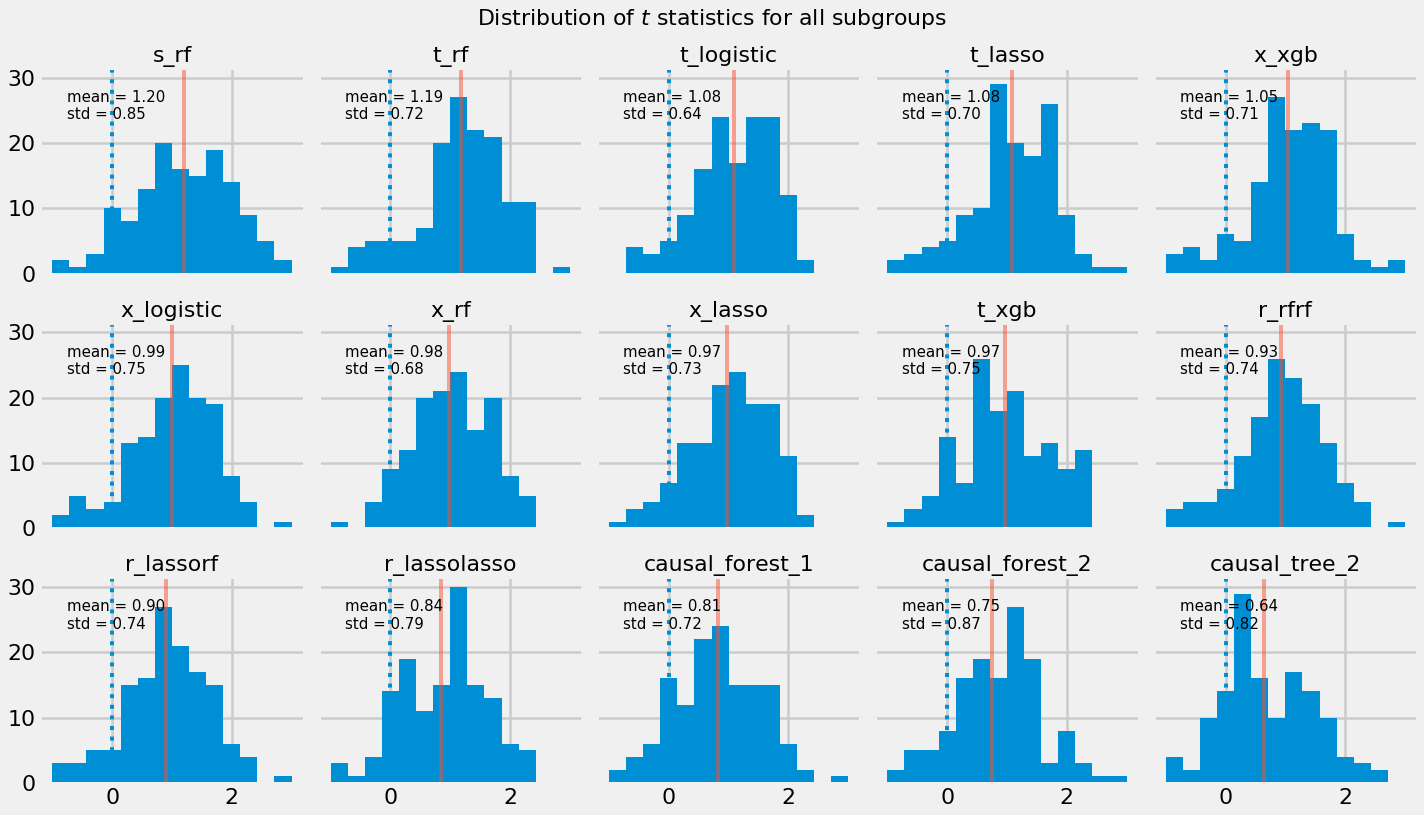

In [9]:
f, axes = plt.subplots(3, 5, figsize=[20, 11], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(scores_df.loc[estimator], bins = np.linspace(-1,3,15))
    mean_score = scores_df.loc[estimator].mean()
    score_std = scores_df.loc[estimator].std()
    ax.axvline(mean_score, linestyle='-', color=colors[1], alpha=0.5)
    ax.axvline(0, alpha=1., linestyle=':')
    ax.annotate(f"mean = {mean_score:.2f}\nstd = {score_std:.2f}",
                xy = (.1, .75), xycoords = ax.transAxes,
                fontsize = 15)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle(r"Distribution of $t$ statistics for all subgroups", y = 1.03)
plt.show()

$t$-statistic standard deviation for various estimators roughly comparable.

In [10]:
modified_scores_df = scores_df.drop(index = {"r_lassoxgb", "causal_tree_1", "s_xgb"})
get_t_r2_statistics(modified_scores_df)

,R2
q values,0.013335
perturbations,0.012480
estimators,0.038850


Takeaway: No one stratification factor accounts for a significant amount of the variance in $t$-statistics.

## 4. Selecting the top estimators

### 4.1. Further investigation and plots

We first return to aggregating $t$-statistics within each perturbation type.

In [12]:
results_df = results_df[[ 'pert=none', 'pert=cv_0', 'pert=cv_1', 'pert=cv_time',
                         'pert=elderly_60',
                         'pert=overweight', 
                         'pert=outcome',
                        ]]
ranking_df = results_df.rank(ascending=False)
ranking_df["max"] = ranking_df.apply(np.max, axis = 1)
ranking_df = ranking_df.sort_values("max")
# ranking_df= ranking_df.drop(index="r_lassoxgb")

results_df = results_df.reindex(index=ranking_df.index).round(2)

In [13]:
results_df

,pert=none,pert=cv_0,pert=cv_1,pert=cv_time,pert=elderly_60,pert=overweight,pert=outcome
estimator,,,,,,,
s_rf,0.96,1.29,1.17,1.42,1.29,1.05,1.26
t_lasso,1.06,1.16,0.99,1.02,1.10,1.07,1.14
t_rf,1.10,1.19,0.90,1.25,1.24,1.18,1.45
x_xgb,1.01,1.15,0.89,1.03,1.08,1.04,1.11
t_logistic,1.10,1.16,1.03,1.17,1.17,0.93,1.02
x_logistic,0.97,1.11,0.87,0.94,1.14,0.92,1.01
x_rf,0.90,1.11,0.88,0.91,1.09,0.99,1.02
x_lasso,0.92,1.13,0.80,0.90,1.10,0.94,1.03
t_xgb,0.66,1.06,0.92,1.26,0.95,0.66,1.26


In [14]:
ranking_df

,pert=none,pert=cv_0,pert=cv_1,pert=cv_time,pert=elderly_60,pert=overweight,pert=outcome,max
estimator,,,,,,,,
s_rf,6.0,1.0,1.0,1.0,1.0,3.0,3.0,6.0
t_lasso,3.0,3.0,3.0,6.0,6.0,2.0,5.0,6.0
t_rf,2.0,2.0,6.0,3.0,2.0,1.0,1.0,6.0
x_xgb,4.0,5.0,7.0,5.0,8.0,4.0,7.0,8.0
t_logistic,1.0,4.0,2.0,4.0,3.0,10.0,9.0,10.0
x_logistic,5.0,10.0,10.0,8.0,4.0,11.0,11.0,11.0
x_rf,9.0,11.0,8.0,10.0,7.0,6.0,10.0,11.0
x_lasso,8.0,8.0,12.0,11.0,5.0,9.0,8.0,12.0
t_xgb,14.0,12.0,5.0,2.0,10.0,13.0,4.0,14.0


In [15]:
# Run this to get latex code for table
#print(results_df.round(2).to_latex())

In [18]:
joblib.dump([results_df, ranking_df], f"data_files/{outcome_name}/{outcome_name}_t_boxplot_data")

['data_files/cfd_cardio/cfd_cardio_t_boxplot_data']

In [16]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 23
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
SAVE_PATH  = f"figs/{outcome_name}/"

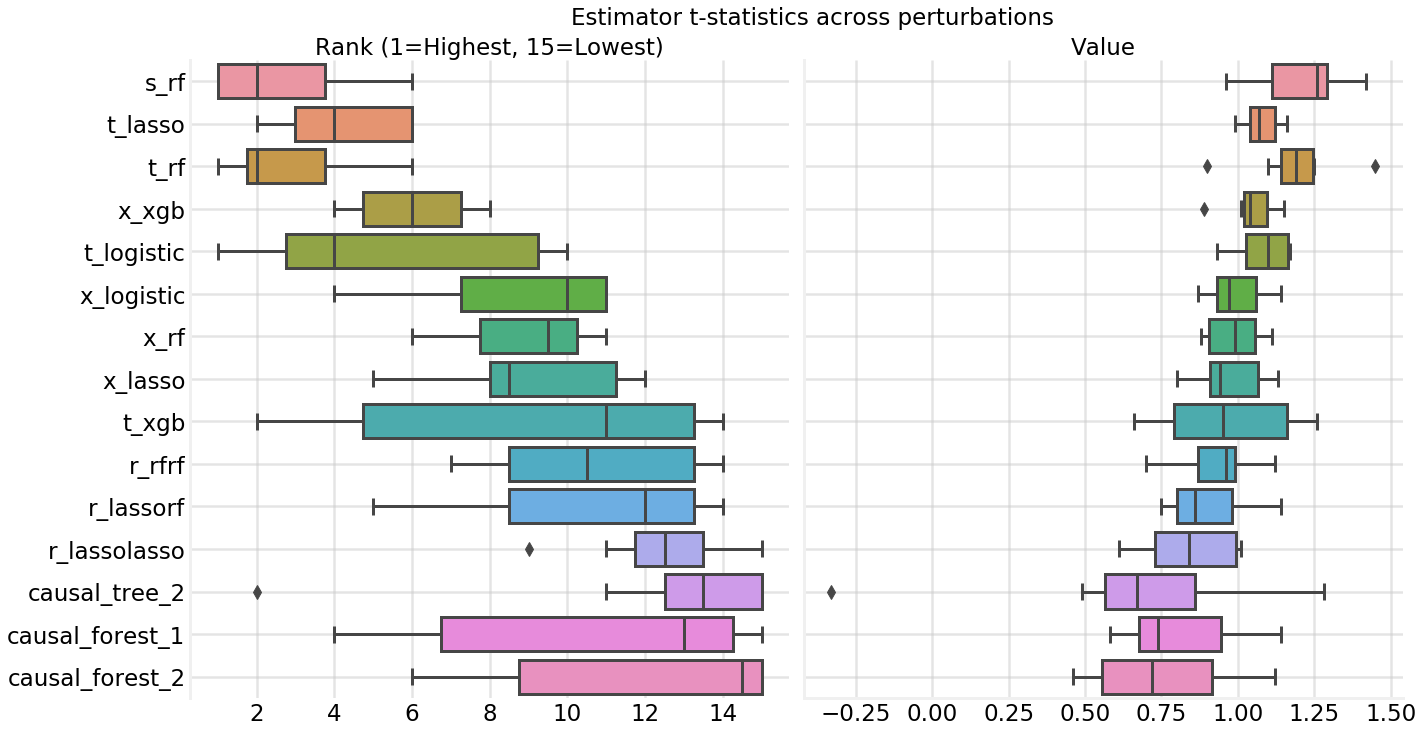

In [26]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=[20, 10])

ax = axes[0]
box_plot = sns.boxplot(data=ranking_df.T, orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Rank (1=Highest, 15=Lowest)", x=0.5, y=1)
ax.grid(True, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")

ax = axes[1]
box_plot = sns.boxplot(data=results_df.reindex(index=ranking_df.index).T, 
                       orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Value", y=1)
ax.grid(True,  alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")
plt.tight_layout()
plt.suptitle("Estimator t-statistics across perturbations", x=0.57, y=1.02)

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_scores_rank_estimators.pdf", bbox_inches='tight')
plt.show()
# sns.boxplot(data=monotonicity_df, ax=ax, fliersize=10, linewidth=3)

### 4.2. Outputting names of top estimators

Let's isolate the estimators whose ranks (within each perturbation type) are always at most 10.

In [17]:
ranking_df["max"] = ranking_df.filter(regex = "pert").max(axis = 1)
ranking_df[ranking_df["max"] <= 10]

,pert=none,pert=cv_0,pert=cv_1,pert=cv_time,pert=elderly_60,pert=overweight,pert=outcome,max
estimator,,,,,,,,
s_rf,6.0,1.0,1.0,1.0,1.0,3.0,3.0,6.0
t_lasso,3.0,3.0,3.0,6.0,6.0,2.0,5.0,6.0
t_rf,2.0,2.0,6.0,3.0,2.0,1.0,1.0,6.0
x_xgb,4.0,5.0,7.0,5.0,8.0,4.0,7.0,8.0
t_logistic,1.0,4.0,2.0,4.0,3.0,10.0,9.0,10.0


Selected estimators: ``s_rf, t_lasso, t_rf, x_xgb, t_logistic``

In [25]:
outcome_name = "cfd_cardio"
top_estimator_names = list(ranking_df[ranking_df["max"] <= 10].index)
joblib.dump(top_estimator_names, f"data_files/{outcome_name}/{outcome_name}_top_estimator_names")

['data_files/cfd_cardio/cfd_cardio_top_estimator_names']